<a href="https://colab.research.google.com/github/ggmeiner22/Camera-Calibration-with-Gradio-UI/blob/main/Camera_Calibration_with_Gradio_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Camera Calibration (OpenCV + Gradio UI)
## In this project, I will calibrate my own camera using OpenCV’s calibration tools.

### The goal is to compute my camera’s intrinsic parameters (focal length, principal point, distortion coefficients).

### I will also build a small Gradio user interface (UI) to streamline the calibration process, visualize results, and demonstrate understanding of camera geometry.



In [27]:
%pip -q install opencv-python-headless numpy gradio plotly pytransform3d==3.3.0

Add imports:

In [28]:
# Standard library imports
import os, json, glob, io, base64, math, textwrap, random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any

# Third-party / scientific stack
import numpy as np
import cv2 as cv                          # OpenCV; aliased as 'cv' by convention
import gradio as gr                       # Gradio UI components for Colab apps
import plotly.graph_objects as go         # Interactive plotting (3D/2D)
from pytransform3d.transformations import plot_transform  # 3D frame viz helper
from PIL import Image                     # Pillow for image I/O/format conversions
import uuid, time                         # UUIDs for unique filenames; timing utilities
import base64, io                         # (Duplicate of earlier base64, io; harmless but redundant)

# --- Paths & filesystem setup (Colab-friendly) ---
# Use a stable base directory in Colab's ephemeral filesystem.
BASE_DIR = "/content"

# Directory to store uploaded or generated images.
IMG_DIR  = os.path.join(BASE_DIR, "images")

# Create the image directory if it doesn't already exist.
os.makedirs(IMG_DIR, exist_ok=True)

# --- Randomness / reproducibility ---
# Deterministic NumPy random number generator for reproducible behavior across runs.
# Prefer NumPy's Generator over np.random for better APIs and stateless functions.
RNG = np.random.default_rng(42)


1) Collect Calibration Images

Save the image into /content/pattern.png

In [29]:
# --- Download the OpenCV checkerboard pattern for calibration ---
import urllib.request

# Publicly hosted checkerboard pattern from OpenCV documentation
url = "https://docs.opencv.org/4.x/pattern.png"

# Save location in Colab filesystem
save_path = "/content/pattern.png"

# Download the file from URL and save locally
urllib.request.urlretrieve(url, save_path)

# Confirm to the user that the file was saved
print(f"Saved checkerboard to {save_path}")

Saved checkerboard to /content/pattern.png


Print the OpenCV chessboard calibration pattern: pattern.png.

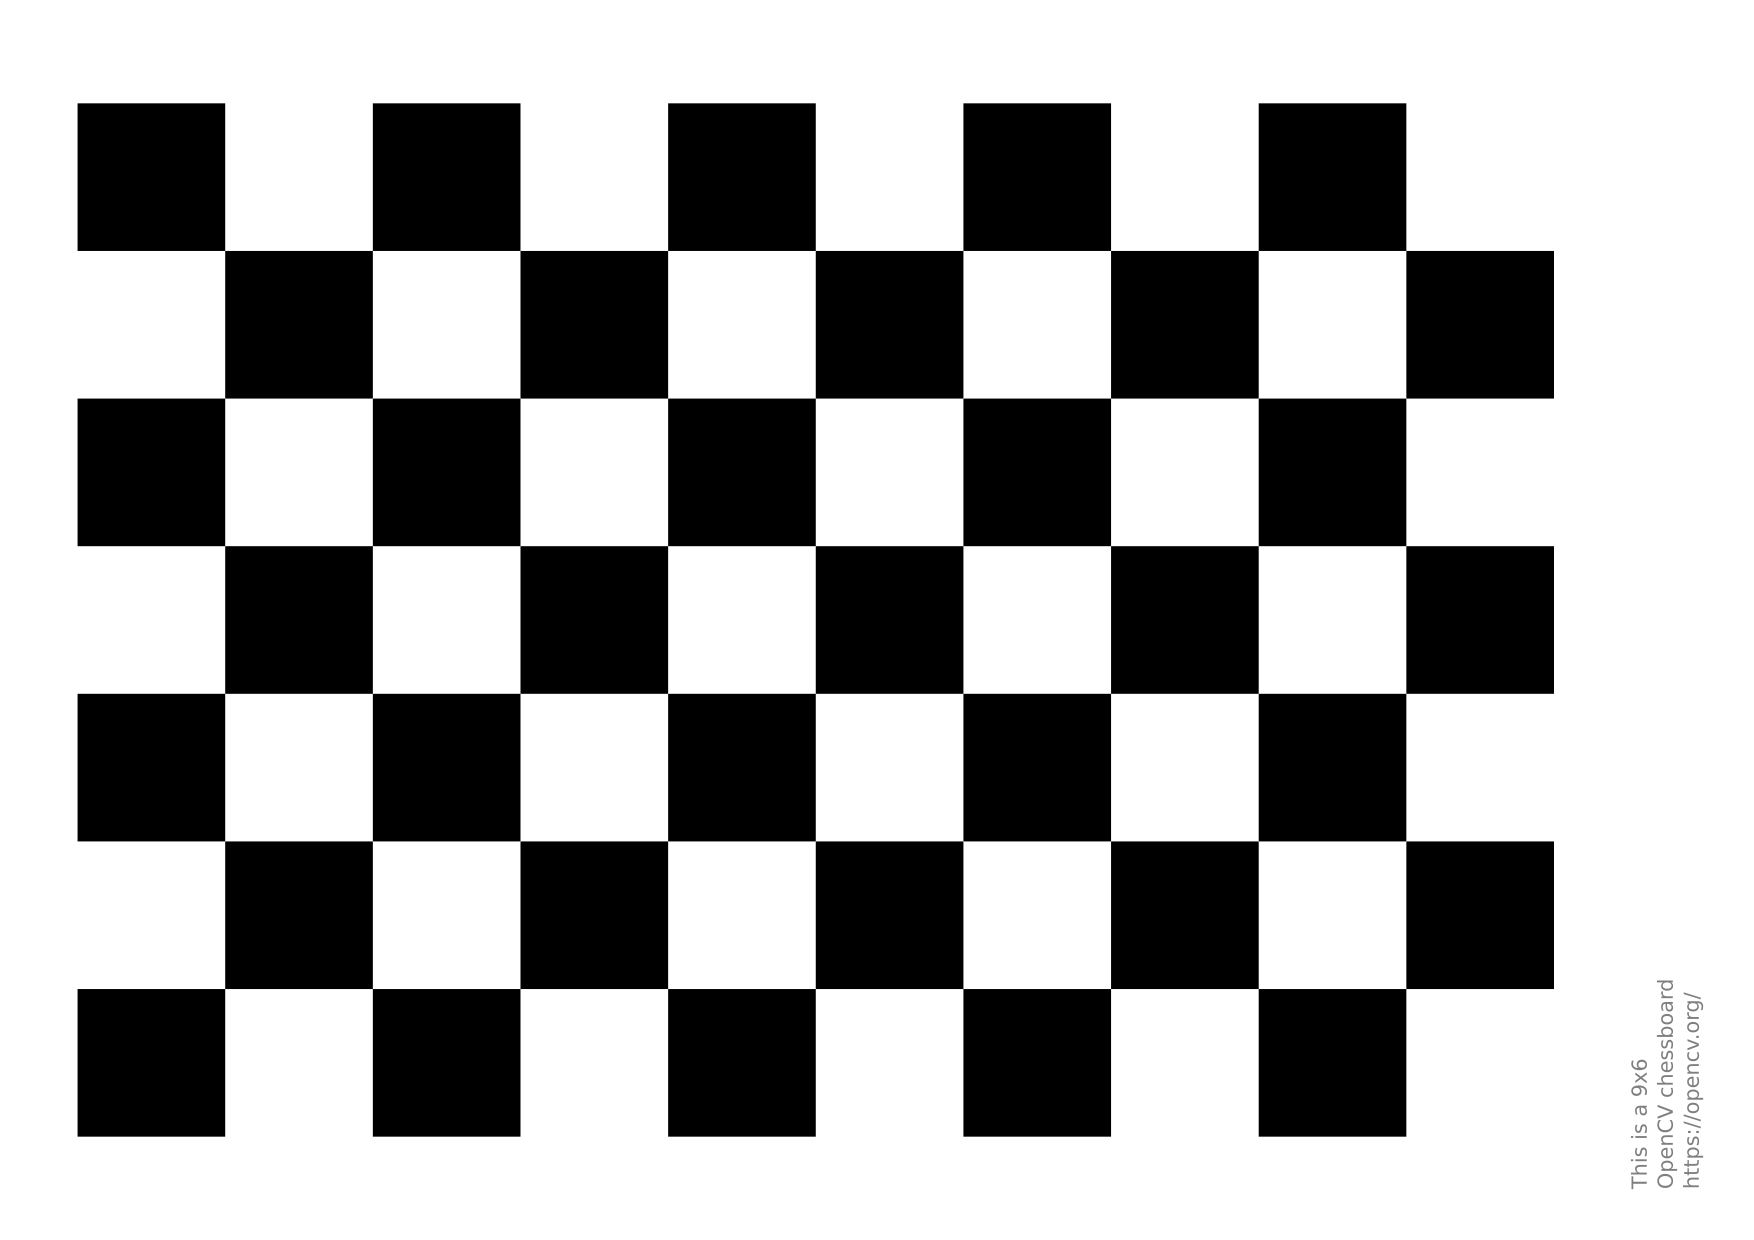

In [30]:
# --- Display the downloaded checkerboard image inside the Colab notebook ---
from IPython.display import Image, display

# Use IPython's display utilities to show the image inline.
# `filename=save_path` points to the chessboard pattern we just saved.
display(Image(filename=save_path))


I/O class

In [31]:
class IO:
    """
    Utility class for common file and image I/O operations.

    Provides static helper methods to handle:
    - Directory creation
    - Image listing
    - JSON read/write
    - Image read/write with automatic BGR↔RGB conversion
    """

    @staticmethod
    def ensure_dir(path: str):
        """Ensure that a directory exists (create if missing)."""
        os.makedirs(path, exist_ok=True)

    @staticmethod
    def list_images(folder: str, exts=(".jpg", ".jpeg", ".png", ".bmp")) -> List[str]:
        """
        Return a sorted list of image file paths in a folder.

        Args:
            folder: Directory to search.
            exts: Tuple of file extensions to include.

        Returns:
            List of matching image paths.
        """
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(folder, f"*{e}")))
        return sorted(files)

    @staticmethod
    def save_json(obj: Dict[str, Any], path: str):
        """
        Save a Python dictionary as a JSON file with indentation.

        Args:
            obj: Serializable dictionary.
            path: Output file path.
        """
        with open(path, "w") as f:
            json.dump(obj, f, indent=2)

    @staticmethod
    def load_json(path: str) -> Dict[str, Any]:
        """
        Load and return a JSON file as a Python dictionary.

        Args:
            path: Path to .json file.

        Returns:
            Parsed dictionary.
        """
        with open(path, "r") as f:
            return json.load(f)

    @staticmethod
    def imread_rgb(path: str) -> np.ndarray:
        """
        Read an image as an RGB NumPy array (OpenCV loads as BGR by default).

        Args:
            path: Path to image file.

        Returns:
            Image array in RGB format (H, W, 3).

        Raises:
            FileNotFoundError: If the image path is invalid or unreadable.
        """
        bgr = cv.imread(path, cv.IMREAD_COLOR)
        if bgr is None:
            raise FileNotFoundError(path)
        return cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

    @staticmethod
    def imwrite_rgb(path: str, rgb: np.ndarray):
        """
        Write an RGB NumPy array to disk (convert to BGR before saving).

        Args:
            path: Output file path.
            rgb: Image array in RGB format (H, W, 3).
        """
        bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
        cv.imwrite(path, bgr)


Board class

In [32]:
class Board:
    """
    Chessboard model for camera calibration.

    Note:
        - `pattern_size` refers to the **number of inner corners**
          (e.g., a 9x6 board has 9×6 inner corners, not squares).
        - Units of the generated object points are determined
          by `square_size_m`.
    """

    @staticmethod
    def object_points(pattern_size: Tuple[int, int], square_size_m: float) -> np.ndarray:
        """
        Generate the 3D world coordinates of chessboard corners.

        Args:
            pattern_size: (cols, rows) = number of inner corners per row/column.
            square_size_m: Size of one square's side in meters (or chosen unit).

        Returns:
            objp: (N, 3) NumPy array of corner coordinates in 3D space,
                  with Z=0 (flat board). Shape = (rows*cols, 3), dtype=float32.
        """
        cols, rows = pattern_size
        objp = np.zeros((rows * cols, 3), np.float32)

        # Generate grid of x,y coordinates for corners
        xs, ys = np.meshgrid(np.arange(cols), np.arange(rows))

        # Fill in X and Y; multiply by square size to convert to real-world units
        objp[:, :2] = np.vstack([xs.ravel(), ys.ravel()]).T * square_size_m

        # Z stays 0 → flat plane
        return objp

    @staticmethod
    def pattern_tuple(cols: int, rows: int) -> Tuple[int, int]:
        """
        Convenience method to return (cols, rows) as a tuple.

        Args:
            cols: Number of inner corners per row.
            rows: Number of inner corners per column.

        Returns:
            Tuple (cols, rows)
        """
        return (cols, rows)


Image class

In [41]:
class Img:
    """
    Image drawing utilities for visualization of calibration results.
    """

    @staticmethod
    def draw_axes(
        rgb: np.ndarray,
        K: np.ndarray,
        D: np.ndarray,
        rvec: np.ndarray,
        tvec: np.ndarray,
        axis_len: float
    ) -> np.ndarray:
        """
        Draw 3D coordinate axes (X, Y, Z) on an RGB image given camera pose.

        Args:
            rgb: Input image in RGB format, shape (H, W, 3), dtype=uint8.
            K: Camera intrinsic matrix (3x3).
            D: Distortion coefficients (OpenCV convention).
            rvec: Rotation vector (Rodrigues form, 3x1).
            tvec: Translation vector (3x1).
            axis_len: Length of the axis lines in world units.

        Returns:
            Copy of the input image with axes drawn:
                - X axis = red
                - Y axis = green
                - Z axis = blue
        """
        img = rgb.copy()

        # Define axis endpoints in 3D (origin + X, Y, Z directions)
        axis_3d = np.float32([
            [0, 0, 0],                  # origin
            [axis_len, 0, 0],           # X-axis
            [0, axis_len, 0],           # Y-axis
            [0, 0, axis_len]            # Z-axis points OUT of the board (toward camera by our visual convention)
        ])

        # Project 3D points into 2D image space
        axis_2d, _ = cv.projectPoints(axis_3d, rvec, tvec, K, D)
        axis_2d = axis_2d.reshape(-1, 2).astype(int)

        # Unpack into named points
        o, x, y, z = map(tuple, axis_2d)

        # Draw lines for each axis in distinct colors
        cv.line(img, o, x, (255, 0, 0), 3)    # X axis → red
        cv.line(img, o, y, (0, 255, 0), 3)    # Y axis → green
        cv.line(img, o, z, (0, 0, 255), 3)    # Z axis → blue

        return img

    @staticmethod
    def put_text(img: np.ndarray, text: str, org=(10, 30)):
        """
        Overlay text on an image (RGB), with a yellow font for visibility.

        Args:
            img: Input image (RGB).
            text: String to draw.
            org: Bottom-left corner of the text string in pixels.

        Returns:
            Copy of the input image with text overlay.
        """
        out = img.copy()
        cv.putText(
            out,
            text,
            org,
            cv.FONT_HERSHEY_SIMPLEX,
            1.0,              # font scale
            (255, 255, 0),    # yellow text (BGR)
            2,                # thickness
            cv.LINE_AA        # anti-aliased text
        )
        return out


Camera class

In [34]:
class Cam:
    """
    Camera-related utilities for calibration and pose handling.
    """

    @staticmethod
    def rodrigues_to_R(rvec: np.ndarray) -> np.ndarray:
        """
        Convert a Rodrigues rotation vector to a 3x3 rotation matrix.

        Args:
            rvec: Rotation vector (3x1 or 1x3), Rodrigues representation.

        Returns:
            R: Rotation matrix (3x3).
        """
        R, _ = cv.Rodrigues(rvec)
        return R

    @staticmethod
    def camera_center_in_board(rvec: np.ndarray, tvec: np.ndarray) -> np.ndarray:
        """
        Compute the camera center in the chessboard/world coordinate system.

        Uses the standard pinhole model:
            X_c = R * X_w + t
        → invert to get camera center in world coords:
            C_w = -R^T * t

        Args:
            rvec: Rotation vector (Rodrigues, 3x1).
            tvec: Translation vector (3x1).

        Returns:
            Camera center in board/world frame as a flat NumPy array (3,).
        """
        R = Cam.rodrigues_to_R(rvec)
        C = -R.T @ tvec.reshape(3, 1)
        return C.flatten()

    @staticmethod
    def to_jsonable(mat: np.ndarray) -> List[List[float]]:
        """
        Convert a NumPy matrix/array to a plain Python list-of-lists.

        Useful for JSON serialization of calibration matrices.

        Args:
            mat: NumPy array.

        Returns:
            Nested lists of floats.
        """
        return mat.tolist()


Calibration class

In [35]:
class Calib:
    """
    Camera calibration pipeline utilities:
      1) Corner detection on a set of chessboard images
      2) Calibration (intrinsics + distortion) from detections
      3) Pose estimation per image (rvec/tvec)
      4) Serialization helpers
    """

    @staticmethod
    def detect_corners(image_paths: List[str], pattern_size: Tuple[int, int]):
        """
        Detect inner-corner points for a chessboard across multiple images.

        Args:
            image_paths: List of image file paths.
            pattern_size: (cols, rows) of inner corners (NOT squares).

        Returns:
            objpoints:   List of (N,3) float32 arrays of object points (Z=0 plane) per image,
                         generated in "unit squares" (square_size = 1.0). Units are scaled later.
            imgpoints:   List of (N,1,2) float32 arrays of detected corner positions per image.
            img_size:    (width, height) tuple inferred from the first valid image.

        Notes:
            - Uses cv.findChessboardCorners + cv.cornerSubPix refinement.
            - If a board is not found in an image, that image is skipped.
        """
        objp_unit = Board.object_points(pattern_size, square_size_m=1.0)  # unit grid; scaled later
        objpoints, imgpoints = [], []
        img_size = None

        for p in image_paths:
            bgr = cv.imread(p, cv.IMREAD_COLOR)
            if bgr is None:
                print(f"[WARN] Could not read image: {p}")
                continue

            gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

            # Cache image size (width, height) from the first readable frame
            if img_size is None:
                img_size = (gray.shape[1], gray.shape[0])

            # Robust flags for various lighting conditions
            ret, corners = cv.findChessboardCorners(
                gray,
                pattern_size,
                flags=cv.CALIB_CB_ADAPTIVE_THRESH + cv.CALIB_CB_NORMALIZE_IMAGE
            )

            if ret:
                # Sub-pixel refinement for higher accuracy (essential for calibration quality)
                corners_ref = cv.cornerSubPix(
                    gray,
                    corners,
                    winSize=(11, 11),
                    zeroZone=(-1, -1),
                    criteria=(cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
                )
                objpoints.append(objp_unit.copy())  # (N,3) float32
                imgpoints.append(corners_ref)       # (N,1,2) float32
            else:
                print(f"[INFO] Chessboard not found: {os.path.basename(p)}")

        return objpoints, imgpoints, img_size

    @staticmethod
    def calibrate(objpoints_unit, imgpoints, img_size, square_size_m: float):
        """
        Calibrate camera intrinsics and distortion from corner detections.

        Args:
            objpoints_unit: List of (N,3) arrays in "unit" board scale (square_size=1.0).
            imgpoints:      List of (N,1,2) arrays of detected pixel corners.
            img_size:       (width, height) image size tuple.
            square_size_m:  Real-world square size to scale object points (meters or chosen unit).

        Returns:
            Dict with:
              - "rms_reprojection_error": float
              - "K": 3x3 camera intrinsics matrix (float64)
              - "D": distortion coefficients (OpenCV format, typically k1..k6, p1, p2, s1..s4 depending on flags)
              - "rvecs": list of rotation vectors per image (Rodrigues, 3x1)
              - "tvecs": list of translation vectors per image (3x1)
              - "image_size": (width, height)

        Notes:
            - Uses cv.CALIB_RATIONAL_MODEL to estimate higher-order radial terms (k4-k6).
            - If no detections are present or img_size is missing, raises ValueError.
        """
        if img_size is None or len(objpoints_unit) == 0:
            raise ValueError("No valid detections or unknown image size.")

        # Convert unit grid to real-world coordinates
        scaled_objpoints = [op * square_size_m for op in objpoints_unit]

        ret, K, D, rvecs, tvecs = cv.calibrateCamera(
            scaled_objpoints,
            imgpoints,
            img_size,     # (width, height)
            cameraMatrix=None,
            distCoeffs=None,
            flags=cv.CALIB_RATIONAL_MODEL
        )

        return {
            "rms_reprojection_error": float(ret),
            "K": K,
            "D": D,
            "rvecs": rvecs,
            "tvecs": tvecs,
            "image_size": img_size
        }

    def undistort_preview(
        rgb: np.ndarray,
        K: np.ndarray,
        D: np.ndarray,
        calib_size: tuple[int, int] | None = None
    ):
        """
        Make a side-by-side style preview for UI: (before_rgb, after_rgb).

        Args:
            rgb:        Input RGB image (H, W, 3), dtype=uint8.
            K:          Intrinsic matrix from calibration.
            D:          Distortion coefficients from calibration.
            calib_size: Optional calibration size (width, height) if rectification maps
                        were computed at a specific size; if provided, pass through.

        Returns:
            Tuple (before_rgb, after_rgb).

        Note:
            - This uses an external helper `undistort_single_after(...)` which must be
              defined elsewhere in your codebase. It should return the undistorted RGB.
        """
        after = undistort_single_after(rgb, K, D, calib_size=calib_size)  # defined elsewhere
        return rgb, after

    @staticmethod
    def save_calibration_json(path: str, calib: Dict[str, Any]):
        """
        Serialize calibration results to a JSON file.

        The matrices/vectors are converted to plain lists for JSON compatibility.

        JSON fields:
            - rms_reprojection_error: float
            - K: 3x3 list-of-lists
            - D: list of distortion coefficients
            - rvecs: list of [3] (flattened)
            - tvecs: list of [3] (flattened)
            - image_width, image_height: ints
        """
        out = {
            "rms_reprojection_error": calib["rms_reprojection_error"],
            "K": Cam.to_jsonable(calib["K"]),
            "D": Cam.to_jsonable(calib["D"]),
            "rvecs": [rv.flatten().tolist() for rv in calib["rvecs"]],
            "tvecs": [tv.flatten().tolist() for tv in calib["tvecs"]],
            "image_width": int(calib["image_size"][0]),
            "image_height": int(calib["image_size"][1]),
        }
        IO.save_json(out, path)

    @staticmethod
    def estimate_poses(image_paths, pattern_size, square_size_m, K, D, imgpoints):
        """
        Estimate camera pose (rvec, tvec) for each image where corners were detected.

        Args:
            image_paths:   List of image paths (aligned with imgpoints order).
            pattern_size:  (cols, rows) of inner corners.
            square_size_m: Real-world square size.
            K:             Intrinsic matrix (3x3).
            D:             Distortion coefficients.
            imgpoints:     List of (N,1,2) detected corners per image.

        Returns:
            List of tuples: (image_path, rvec, tvec) for each successful solvePnP.

        Notes:
            - Uses cv.solvePnP with SOLVEPNP_ITERATIVE (EPnP + Gauss-Newton refinements).
            - Assumes object point ordering matches findChessboardCorners corner ordering.
        """
        objp = Board.object_points(pattern_size, square_size_m)
        results = []
        for pth, corners in zip(image_paths, imgpoints):
            ok, rvec, tvec = cv.solvePnP(
                objp, corners, K, D, flags=cv.SOLVEPNP_ITERATIVE
            )
            if ok:
                results.append((pth, rvec, tvec))
        return results


Pose plot (3D) helper + full pipeline function

In [36]:
def plot_camera_poses_3d(
    pose_list: List[Tuple[str, np.ndarray, np.ndarray]],
    square_size_m: float
):
    """
    Visualize estimated camera centers in the chessboard/world frame.

    Args:
        pose_list: List of (image_path, rvec, tvec) for each image with a solved pose.
                   rvec/tvec express the camera pose w.r.t. the board (world) frame.
        square_size_m: Real-world size of one chessboard square (for axis/grid scaling).

    Returns:
        Plotly Figure with:
          - A faint board grid lying on Z=0 (world XY plane)
          - Camera centers as markers labeled #0, #1, …
          - Board axes (X, Y, Z) drawn at the origin

    Notes:
        - World frame convention (from earlier):
            Board lies in Z=0; units are meters if `square_size_m` is in meters.
        - Camera center is computed as C_w = -R^T * t (already done upstream).
    """
    fig = go.Figure()
    if len(pose_list) == 0:
        # Nothing to plot → keep consistent aspect mode so axes don't distort
        fig.update_layout(title="No poses to display", scene_aspectmode='data')
        return fig










    # Camera centers
    centers, labels = [], []
    for pth, rvec, tvec in pose_list:
        C = Cam.camera_center_in_board(rvec, tvec)   # shape (3,)
        centers.append(C)                            # keep as array/list; we'll cast below
        labels.append(os.path.basename(pth))

    # Cast to NumPy BEFORE any [:, ...] indexing
    centers = np.asarray(centers, dtype=float)       # shape (N, 3)

    # Flip Z so cameras in front of the board appear at +Z (matches overlay)
    centers[:, 2] *= -1

    fig.add_trace(go.Scatter3d(
        x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
        mode="markers+text",
        text=[f"#{i}" for i in range(len(labels))],
        textposition="top center",
        marker=dict(size=4), name="Camera centers"
    ))

    # --- Board axes drawn at the origin (0,0,0) ---
    L = 3.0 * square_size_m  # axis length in world units
    axes = {
        "X": [[0, L], [0, 0], [0, 0]],
        "Y": [[0, 0], [0, L], [0, 0]],
        "Z": [[0, 0], [0, 0], [0, L]],
    }
    for name, (ax, ay, az) in axes.items():
        fig.add_trace(go.Scatter3d(x=ax, y=ay, z=az, mode="lines", name=f"{name}-axis"))

    # Keep aspect ratio true to data scale; label axes with units
    fig.update_layout(
        title="Estimated Camera Poses w.r.t. Chessboard",
        scene=dict(
            xaxis_title="X (m)", yaxis_title="Y (m)", zaxis_title="Z (m)",
            aspectmode="data"
        ),
        legend=dict(x=0, y=1.0)
    )
    return fig


def run_full_calibration(
    image_dir: str,
    pattern_cols: int,
    pattern_rows: int,
    square_size_m: float,
    max_overlay_images: int = 8,
    save_json_path: str = os.path.join(BASE_DIR, "calibration.json")
) -> Dict[str, Any]:
    """
    End-to-end calibration driver:
      - Load images
      - Detect chessboard corners
      - Calibrate (K, D)
      - Estimate per-image poses
      - Produce overlay visuals, an undistort preview, and a 3D pose plot
      - Save results as JSON

    Args:
        image_dir: Directory containing calibration images.
        pattern_cols: Number of inner corners per row (columns).
        pattern_rows: Number of inner corners per column (rows).
        square_size_m: Real-world size of each square's side (meters or chosen unit).
        max_overlay_images: Max random examples to render with drawn axes.
        save_json_path: Output JSON path for calibration results.

    Returns:
        Dict containing:
            - "json_path": path to saved calibration JSON
            - "rms": RMS reprojection error
            - "K": intrinsics matrix (3x3)
            - "D": distortion coefficients
            - "image_size": (width, height)
            - "num_images": total images found
            - "num_used": images with valid detections
            - "overlay_images": list of RGB images with axes drawn
            - "undist_before": sample RGB before undistortion (or None)
            - "undist_after": sample RGB after undistortion (or None)
            - "pose_fig": Plotly Figure with camera centers and axes

    Raises:
        RuntimeError: if no images are found or if too few detections are available.
        ValueError:   propagated from calibration if image size/detections are invalid.

    Notes:
        - Requires `undistort_single_after(...)` used by `Calib.undistort_preview` to be
          defined elsewhere (should return an undistorted RGB).
        - Heuristic: requires at least 8 successful board detections for a stable solve.
    """
    pattern_size = Board.pattern_tuple(pattern_cols, pattern_rows)

    # Gather input images; fail early if none present
    image_paths = IO.list_images(image_dir)
    if len(image_paths) == 0:
        raise RuntimeError(f"No images found in {image_dir}. Upload .jpeg files first.")

    # Detect corners across the dataset
    objpoints_unit, imgpoints, img_size = Calib.detect_corners(image_paths, pattern_size)
    if len(imgpoints) < 8:
        raise RuntimeError(f"Not enough valid detections: {len(imgpoints)} found; need ≥ 8.")

    # Calibrate intrinsics + distortion
    calib = Calib.calibrate(objpoints_unit, imgpoints, img_size, square_size_m)

    # Persist results
    Calib.save_calibration_json(save_json_path, calib)

    # Estimate per-image poses using the found corners
    K, D = calib["K"], calib["D"]
    pose_list = Calib.estimate_poses(image_paths, pattern_size, square_size_m, K, D, imgpoints)

    # --- Create sample axis overlays on random subset of images ---
    idxs = list(range(len(pose_list)))
    random.shuffle(idxs)
    idxs = idxs[:max_overlay_images]
    overlay_images = []
    for i in idxs:
        pth, rvec, tvec = pose_list[i]
        rgb = IO.imread_rgb(pth)
        img_axes = Img.draw_axes(rgb, K, D, rvec, tvec, axis_len=3.0 * square_size_m)
        overlay_images.append(Img.put_text(img_axes, f"axes: {os.path.basename(pth)}", (10, 30)))

    # --- Undistortion preview on the first successful image (if any) ---
    undist_before = undist_after = None
    if len(pose_list) > 0:
        p0, _, _ = pose_list[0]
        img0 = IO.imread_rgb(p0)
        # calib["image_size"] is (width, height) in this pipeline
        undist_before, undist_after = Calib.undistort_preview(
            img0, K, D, calib_size=tuple(calib["image_size"])
        )

    # 3D plot of camera centers + board axes
    fig = plot_camera_poses_3d(pose_list, square_size_m)

    return {
        "json_path": save_json_path,
        "rms": calib["rms_reprojection_error"],
        "K": calib["K"],
        "D": calib["D"],
        "image_size": calib["image_size"],
        "num_images": len(image_paths),
        "num_used": len(imgpoints),
        "overlay_images": overlay_images,
        "undist_before": undist_before,
        "undist_after": undist_after,
        "pose_fig": fig
    }


Helper functions to save images to files

In [37]:
# Directory for UI images
EXPORT_DIR = os.path.join(BASE_DIR, "exports")
IO.ensure_dir(EXPORT_DIR)

def _to_file_list(images, prefix="overlay"):
    """
    Save a list of RGB numpy images to PNG files and return their paths.
    """
    paths = []
    for i, img in enumerate(images):
        fp = os.path.join(EXPORT_DIR, f"{prefix}_{i:02d}.png")
        IO.imwrite_rgb(fp, img)  # writes RGB -> PNG
        paths.append(fp)
    return paths

EXPORT_ROOT = os.path.join(BASE_DIR, "exports")
IO.ensure_dir(EXPORT_ROOT)

def _save_gallery_images_np(images, prefix="overlay", max_side=1600):
    """
    Accepts a list of RGB uint8 numpy arrays and returns a list of fresh, unique PNG file paths.
    Resizes if images are very large to avoid Colab/Gradio rendering issues.
    """
    # Create a unique “session” folder each run to dodge caching/collisions
    session_dir = os.path.join(EXPORT_ROOT, f"{prefix}_{int(time.time())}_{uuid.uuid4().hex[:6]}")
    IO.ensure_dir(session_dir)

    paths = []
    for i, arr in enumerate(images):
        if arr is None:
            continue
        # Ensure uint8 RGB
        if arr.dtype != np.uint8:
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        if arr.ndim == 2:
            arr = np.stack([arr]*3, axis=-1)
        if arr.shape[2] == 4:  # RGBA -> RGB
            arr = arr[..., :3]

        im = Image.fromarray(arr, mode="RGB")
        # Downscale large images for more reliable display
        w, h = im.size
        scale = min(1.0, max_side / max(w, h))
        if scale < 1.0:
            im = im.resize((int(w*scale), int(h*scale)), Image.LANCZOS)

        fp = os.path.join(session_dir, f"{prefix}_{i:02d}.png")
        im.save(fp, format="PNG", optimize=True)
        paths.append(fp)
    return paths

def _to_rgb_uint8(img: np.ndarray) -> np.ndarray:
    """Return a contiguous RGB uint8 HxWx3 image (downscale if huge)."""
    if img is None:
        return None

    arr = img
    # Ensure uint8 range
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)

    # Expand gray to RGB
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)

    # Drop alpha if present
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]

    # Sometimes arrays come in BGR; our pipeline produces RGB, but to be safe:
    # If you KNOW an array is BGR, uncomment:
    # arr = cv.cvtColor(arr, cv.COLOR_BGR2RGB)

    # Downscale very large images for Colab stability
    h, w = arr.shape[:2]
    max_side = 1200
    scale = min(1.0, max_side / float(max(h, w)))
    if scale < 1.0:
        arr = cv.resize(arr, (int(round(w*scale)), int(round(h*scale))), interpolation=cv.INTER_AREA)

    # Make sure memory is contiguous; Gradio can be picky here
    arr = np.ascontiguousarray(arr)
    return arr

def _to_pil_rgb(img_np, max_side=1200):
    if img_np is None or img_np.size == 0:
        return None
    if img_np.ndim < 2:
        return None
    arr = img_np
    if arr.dtype != np.uint8:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr]*3, axis=-1)
    if arr.ndim == 3 and arr.shape[2] == 4:
        arr = arr[:, :, :3]
    h, w = arr.shape[:2]
    if h == 0 or w == 0:
        return None
    scale = min(1.0, max_side / float(max(h, w)))
    if scale < 1.0:
        nh, nw = int(round(h*scale)), int(round(w*scale))
        if nh > 0 and nw > 0:
            arr = cv.resize(arr, (nw, nh), interpolation=cv.INTER_AREA)
    return Image.fromarray(arr, mode="RGB")


def _prep_gallery_pil(images_list):
    out = []
    for im in images_list or []:
        pi = _to_pil_rgb(im)
        if pi is not None:          # skip empties
            out.append(pi)
    return out

from PIL import Image

def _pil_to_base64(img: Image.Image) -> str:
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("ascii")

def _imgs_to_html(pils, captions=None, max_w=380):
    if not pils:
        return "<div style='color:#bbb'>No images to display.</div>"
    cards = []
    for i, im in enumerate(pils):
        b64 = _pil_to_base64(im)
        cap = (captions[i] if captions and i < len(captions) else "")
        cards.append(
            f"""
            <div style="display:flex;flex-direction:column;align-items:center;margin:8px;">
              <img src="data:image/png;base64,{b64}" style="max-width:{max_w}px;height:auto;border:1px solid #444;border-radius:6px;" />
              <div style="color:#ccc;font-size:12px;margin-top:4px">{cap}</div>
            </div>
            """
        )
    return f"<div style='display:flex;flex-wrap:wrap;'>{''.join(cards)}</div>"

Helper function for undistortion

In [38]:
def undistort_single_after(rgb: np.ndarray, K: np.ndarray, D: np.ndarray,
                           calib_size: tuple[int, int] | None = None) -> np.ndarray:
    """
    Return just the undistorted image (RGB, uint8) for one input frame.

    rgb         : HxWx3, RGB, uint8
    K, D        : intrinsics and distortion from calibration (float64 recommended)
    calib_size  : (calib_width, calib_height) from calibration. If present and the
                  input image size differs, K is scaled accordingly.
    """
    assert rgb.ndim == 3 and rgb.shape[2] == 3, "rgb must be HxWx3 RGB"
    h, w = rgb.shape[:2]

    # Ensure expected types/shapes for OpenCV
    K = np.asarray(K, dtype=np.float64).copy()
    D = np.asarray(D, dtype=np.float64).reshape(-1)

    # If current image size != calibration size, scale K
    if calib_size is not None:
        cw, ch = calib_size  # width, height from calibration
        if (w, h) != (cw, ch):
            sx, sy = w / float(cw), h / float(ch)
            K[0, 0] *= sx       # fx
            K[0, 2] *= sx       # cx
            K[1, 1] *= sy       # fy
            K[1, 2] *= sy       # cy

    # Build rectification map and remap (more stable than single-call undistort)
    newK, _ = cv.getOptimalNewCameraMatrix(
        K, D, (w, h), alpha=0.5, centerPrincipalPoint=True
    )
    map1, map2 = cv.initUndistortRectifyMap(K, D, None, newK, (w, h), cv.CV_16SC2)

    bgr_in  = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
    bgr_out = cv.remap(bgr_in, map1, map2, interpolation=cv.INTER_LINEAR,
                       borderMode=cv.BORDER_CONSTANT)
    return cv.cvtColor(bgr_out, cv.COLOR_BGR2RGB)


Build a Gradio Inline UI

In [39]:
# --- Simple app-level state (paths shared across callbacks) ---
STATE = {
    "image_dir": IMG_DIR,
    "last_calib_json": os.path.join(BASE_DIR, "calibration.json")
}


def ui_save_uploads(files):
    """
    Save uploaded images into STATE['image_dir'] and return a status line + list of paths.

    Args:
        files: List of file-like objects from gr.Files() (Gradio temp files). Each f has .name

    Returns:
        (status_markdown: str, image_paths_json: list[str])
    """
    IO.ensure_dir(STATE["image_dir"])
    saved = 0
    paths = []

    # Gradio passes None/[] when nothing selected
    if not files:
        return "No files uploaded.", []

    for f in files:
        # Use original filename (basename) and copy from Gradio's temp file path
        fname = os.path.basename(f.name)
        dst = os.path.join(STATE["image_dir"], fname)
        # NOTE: This overwrites silently if filenames collide; acceptable for quick demos.
        # If you want to avoid collisions, consider prefixing with uuid4.
        with open(f.name, "rb") as src, open(dst, "wb") as out:
            out.write(src.read())
        saved += 1
        paths.append(dst)

    # Return a friendly status and the **current** directory listing (sorted)
    return f"Saved {saved} image(s) to {STATE['image_dir']}", IO.list_images(STATE["image_dir"])


def ui_run_calibration(pattern_cols, pattern_rows, square_size_m, max_overlay):
    """
    Run calibration and prepare UI outputs (text, 3D plot, overlays HTML, undistort HTML).

    Args:
        pattern_cols: Inner-corner columns (int-like; gr.Number -> float, cast below)
        pattern_rows: Inner-corner rows (int-like; gr.Number -> float, cast below)
        square_size_m: Square side length in meters (float)
        max_overlay: Max number of overlay images to render (int)

    Returns:
        Tuple:
          - info_markdown (str)
          - pose_fig (plotly.Figure)
          - overlay_html (str)
          - undist_html (str)

    Notes:
        - Depends on helpers: _prep_gallery_pil, _imgs_to_html, _to_pil_rgb
        - Also uses Calib.undistort_preview which calls `undistort_single_after(...)` (defined elsewhere).
        - Keeps output TYPES identical on success and on error (important for Gradio wiring).
    """
    try:
        result = run_full_calibration(
            image_dir=STATE["image_dir"],
            pattern_cols=int(pattern_cols),
            pattern_rows=int(pattern_rows),
            square_size_m=float(square_size_m),
            max_overlay_images=int(max_overlay),
            save_json_path=STATE["last_calib_json"],
        )

        # Summary block for the UI (markdown)
        info = (
            f"✅ Calibration completed\n"
            f"• RMS reprojection error: {result['rms']:.4f}\n"
            f"• Images in folder: {result['num_images']}\n"
            f"• Used with valid corners: {result['num_used']}\n"
            f"• Image size: {result['image_size'][0]} x {result['image_size'][1]}\n"
            f"• Saved: {result['json_path']}"
        )

        # ------- overlays -> HTML gallery -------
        # result['overlay_images'] is a list of RGB np.ndarrays
        overlay_pil = _prep_gallery_pil(result["overlay_images"])  # expects list[PIL.Image]
        overlay_caps = [f"axes {i+1}" for i in range(len(overlay_pil))]  # align captions with produced overlays
        overlay_html_str = _imgs_to_html(overlay_pil, captions=overlay_caps, max_w=360)

        # ------- undistortion (2 panels) -> HTML -------
        undist_html_str = "<div style='color:#bbb'>No undistortion preview.</div>"
        if result["undist_before"] is not None:
            before_np = result["undist_before"]
            after_np  = result["undist_after"]

            # Convert to PIL for consistent HTML gallery rendering
            before_pil = _to_pil_rgb(before_np)
            after_pil  = _to_pil_rgb(after_np)

            # Be defensive: if "after" failed, mirror "before" so UI still shows 2 images
            if after_pil is None:
                after_pil = before_pil

            if before_pil is None:
                undist_html_str = "<div style='color:#f88'>Undistortion preview unavailable.</div>"
            else:
                undist_html_str = _imgs_to_html([before_pil, after_pil],
                                                captions=["Before", "After"], max_w=480)

        # pose_fig is a Plotly figure created by plot_camera_poses_3d (works with gr.Plot)
        return info, result["pose_fig"], overlay_html_str, undist_html_str

    except Exception as e:
        # Keep outputs the same types as on success to avoid UI wiring errors
        err = f"❌ {type(e).__name__}: {e}"
        return (
            err,
            go.Figure(),  # empty figure
            f"<div style='color:#f88'>{err}</div>",
            f"<div style='color:#f88'>{err}</div>"
        )


# --- Gradio UI layout ---
with gr.Blocks(title="Camera Calibration (OpenCV + Gradio)") as demo:
    gr.Markdown(
        "# 📷 Camera Calibration — OpenCV + Gradio\n"
        "Upload chessboard photos, then run calibration. Results saved to `calibration.json`."
    )

    # ----- Tab 1: Upload -----
    with gr.Tab("1) Upload Images"):
        # Accept multiple image files; Gradio supplies temporary file objects
        files = gr.Files(file_types=["image"], file_count="multiple", label="Upload .jpeg images")
        status = gr.Markdown()
        # Show the current image paths in /content/images (JSON widget is convenient for lists)
        gallery_list = gr.JSON(label="Current images in /content/images (paths)")
        save_btn = gr.Button("Save to /content/images")
        save_btn.click(fn=ui_save_uploads, inputs=files, outputs=[status, gallery_list])

    # ----- Tab 2: Calibrate -----
    with gr.Tab("2) Calibrate & Visualize"):
        with gr.Row():
            # Use integer-like Numbers for pattern; casts happen inside the callback
            pattern_cols = gr.Number(value=9, precision=0, label="Inner corners (cols)")
            pattern_rows = gr.Number(value=6, precision=0, label="Inner corners (rows)")
            # ≈ 21.77 mm (about 6/7 inch) — adjust to your printed board
            square_size  = gr.Number(value=0.0217714286, label="Square size (meters)")
            max_overlay  = gr.Slider(3, 12, value=8, step=1, label="Sample overlays to show")

        run_btn = gr.Button("▶️ Run Calibration")
        out_info = gr.Markdown()
        pose_fig = gr.Plot(label="Camera Poses (3D)")     # accepts Plotly Figure
        overlay_html = gr.HTML(label="Detected pattern + world axes")
        undist_html  = gr.HTML(label="Undistortion (before/after)")

        # Wire the button to the calibration pipeline
        run_btn.click(
            fn=ui_run_calibration,
            inputs=[pattern_cols, pattern_rows, square_size, max_overlay],
            outputs=[out_info, pose_fig, overlay_html, undist_html]
        )

# Launch inline in Colab; share=False limits to the current session
demo.launch(inline=True, share=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>